In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
# !! unzip data.zip

In [3]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

Sequences
0  MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1  MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2  MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3  MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4  MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...

In [4]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))

    return codones

In [5]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [7]:
######################

In [8]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    
    size = len(index_words_list)
    random_indices = list(range(size))
    
    while(True):
        i = random.choice(random_indices)
        
        sub_lst = index_words_list[i]
        sub_size = len(sub_lst)
        
        index = random.randint(0, max(0, sub_size - 1))
        context = random.randint(1, context_window_size)
        
#         start_index = max(0, index - context)
#         end_index = min(sub_size - 1, index + context)
#         if 
#         target_index = random.randint(start_index, end_index)
        
        targets = []
        targets.extend(list(sub_lst[max(0, index - context): index]))
        targets.extend(list(sub_lst[index + 1: index + context + 1]))
                               
#         random.shuffle(targets)
#         center = sub_lst[index]
        
#         for target in targets:
#             yield center, target
        
        if len(targets) == 0:
            continue        
            
        center = sub_lst[index]
        target = random.choice(targets)
        
        yield center, target


#     random.shuffle(random_indices)
    
# #     for index_words in index_words_list:
# #         for index, center in enumerate(index_words):

#     for i in random_indices:
        
#         sub_lst = index_words_list[i]
#         sub_size = len(sub_lst)
#         sub_random_indices = list(range(sub_size))
#         random.shuffle(sub_random_indices)
        
#         for index in sub_random_indices:
#             center = sub_lst[index]
#             context = random.randint(1, context_window_size)
#             targets = []
#             targets.extend(list(sub_lst[max(0, index - context): index]))
#             targets.extend(list(sub_lst[index + 1: index + context + 1]))
#             random.shuffle(targets)
            
#             for target in targets:
#                 yield center, target
            
        
        
#         for index, center in enumerate(index_words_list[i]):
#             context = random.randint(1, context_window_size)
            
#             # get a random target before the center word
# #             for target in index_words[max(0, index - context): index]:
#             for target in index_words_list[i][max(0, index - context): index]:
#                 yield center, target
            
#             # get a random target after the center wrod
# #             for target in index_words[index + 1: index + context + 1]:
#             for target in index_words_list[i][index + 1: index + context + 1]:
#                 yield center, target


def get_batch(batch_size, 
              index_words_list, context_window_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    
    size = len(index_words_list)
    random_indices = list(range(size))
    
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        
        batch_index = 0
        
        while(batch_index < batch_size):
            i = random.choice(random_indices)
        
            sub_lst = index_words_list[i]
            sub_size = len(sub_lst)

            index = random.randint(0, max(0, sub_size - 1))
            context = random.randint(1, context_window_size)

            targets = []
            targets.extend(list(sub_lst[max(0, index - context): index]))
            targets.extend(list(sub_lst[index + 1: index + context + 1]))

            if len(targets) == 0:
                continue        

            center = sub_lst[index]
            target = random.choice(targets)
            
            center_batch[batch_index], target_batch[batch_index] = center, target
            batch_index += 1
            
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]


def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    
    counter = Counter(flat_codones)
    
    unique_codones = list(set(flat_codones))
    unique_codones = sorted(unique_codones, key=lambda x: counter[x], 
                            reverse=False)
            
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary


def process_data(all_codones, dictionary, batch_size, skip_window):    
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]   
    
#     single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(batch_size=batch_size, 
                          index_words_list=cod_dicts, 
                          context_window_size=skip_window)
    return batch_gen

In [9]:
# all_codones = np.array([[['abc', 'gec', 'agc'], ['get', 'ghe', 'acg']]])

dictionary = make_dictionary(all_codones)

In [10]:
BATCH_SIZE = 256
SKIP_WINDOW = 10  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [11]:
######################

In [12]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

class SkipGramModel:
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        self.saver = tf.train.Saver()  # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')

    def _create_fully_conn(self, input_tensor, from_n, to_n, layer_name):
        with tf.name_scope(layer_name):
            W_fc = weight_variable(shape=[from_n, to_n], name=layer_name + '_W')
            b_fc = bias_variable(shape=[to_n], name=layer_name + '_b')
            h_fc = tf.nn.tanh(tf.add(tf.matmul(input_tensor, W_fc), b_fc))
            return h_fc
           
    def _create_fully_conn_logit(self, input_tensor, from_n, to_n, layer_name):
        with tf.name_scope(layer_name):
            W_fc = weight_variable(shape=[from_n, to_n], name=layer_name + '_W')
            b_fc = bias_variable(shape=[to_n], name=layer_name + '_b')
            h_fc = tf.add(tf.matmul(input_tensor, W_fc), b_fc)
            return h_fc        
    
    def _create_embedding(self):
        with tf.name_scope("embed"):
            self.embed_matrix = tf.Variable(tf.random_uniform([self.vocab_size,
                                                               self.embed_size], -1.0, 1.0),
                                            name='embed_matrix')

    def _create_loss(self):
        with tf.name_scope("loss"):
            embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')

            # construct variables for NCE loss
            nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                         stddev=1.0 / (self.embed_size ** 0.5)),
                                     name='nce_weight')
            
#             nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name='nce_bias')
            nce_bias = tf.Variable(tf.truncated_normal([self.vocab_size], stddev=1.0 / (self.embed_size ** 0.5)), 
                                   name='nce_bias')
            
            # define loss function to be NCE loss function
            self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                      biases=nce_bias,
                                                      labels=self.target_words,
                                                      inputs=embed,
#                                                       inputs=fc4,
                                                      num_sampled=self.num_sampled,
                                                      num_classes=self.vocab_size), name='loss')

    def _create_optimizer(self):
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)
#         self.optimizer = tf.train.AdamOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)

        
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._create_placeholders()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

In [13]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .9
NUM_TRAIN_STEPS = 3000000
SKIP_STEP = 2000

g = tf.Graph()
with g.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, 
                          BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()

INFO:tensorflow:Summary name histogram loss is illegal; using histogram_loss instead.


In [14]:
######################

In [15]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [16]:
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    make_dir('checkpoints')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
    
    with tf.Session(graph=g, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
#         if that checkpoint exists, restore from checkpoint
        if ckpt and os.path.isfile(ckpt.model_checkpoint_path):
            model.saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op],
                                              feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                print('Average loss at step {}: {:5.3f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                model.saver.save(sess, 'checkpoints/skip-gram', index)

        final_embed_matrix = sess.run(model.embed_matrix)
        return final_embed_matrix

In [17]:
final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

Average loss at step 1999: 17.188
Average loss at step 3999: 13.071
Average loss at step 5999: 11.105
Average loss at step 7999: 9.081
Average loss at step 9999: 7.197
Average loss at step 11999: 5.684
Average loss at step 13999: 4.671
Average loss at step 15999: 4.284
Average loss at step 17999: 3.370
Average loss at step 19999: 2.974
Average loss at step 21999: 2.728
Average loss at step 23999: 2.615
Average loss at step 25999: 2.242
Average loss at step 27999: 2.079
Average loss at step 29999: 2.030
Average loss at step 31999: 1.984
Average loss at step 33999: 1.894
Average loss at step 35999: 1.768
Average loss at step 37999: 1.679
Average loss at step 39999: 1.689
Average loss at step 41999: 1.620
Average loss at step 43999: 1.552
Average loss at step 45999: 1.552
Average loss at step 47999: 1.577
Average loss at step 49999: 1.513
Average loss at step 51999: 1.500
Average loss at step 53999: 1.469
Average loss at step 55999: 1.409
Average loss at step 57999: 1.393
Average loss at 

Average loss at step 473999: 1.160
Average loss at step 475999: 1.128
Average loss at step 477999: 1.123
Average loss at step 479999: 1.164
Average loss at step 481999: 1.149
Average loss at step 483999: 1.133
Average loss at step 485999: 1.146
Average loss at step 487999: 1.127
Average loss at step 489999: 1.123
Average loss at step 491999: 1.129
Average loss at step 493999: 1.101
Average loss at step 495999: 1.161
Average loss at step 497999: 1.124
Average loss at step 499999: 1.138
Average loss at step 501999: 1.128
Average loss at step 503999: 1.134
Average loss at step 505999: 1.089
Average loss at step 507999: 1.139
Average loss at step 509999: 1.154
Average loss at step 511999: 1.166
Average loss at step 513999: 1.131
Average loss at step 515999: 1.107
Average loss at step 517999: 1.088
Average loss at step 519999: 1.133
Average loss at step 521999: 1.126
Average loss at step 523999: 1.165
Average loss at step 525999: 1.151
Average loss at step 527999: 1.168
Average loss at step

Average loss at step 943999: 1.069
Average loss at step 945999: 1.094
Average loss at step 947999: 1.107
Average loss at step 949999: 1.080
Average loss at step 951999: 1.135
Average loss at step 953999: 1.115
Average loss at step 955999: 1.107
Average loss at step 957999: 1.107
Average loss at step 959999: 1.088
Average loss at step 961999: 1.120
Average loss at step 963999: 1.104
Average loss at step 965999: 1.088
Average loss at step 967999: 1.082
Average loss at step 969999: 1.100
Average loss at step 971999: 1.108
Average loss at step 973999: 1.105
Average loss at step 975999: 1.098
Average loss at step 977999: 1.110
Average loss at step 979999: 1.107
Average loss at step 981999: 1.092
Average loss at step 983999: 1.097
Average loss at step 985999: 1.108
Average loss at step 987999: 1.125
Average loss at step 989999: 1.120
Average loss at step 991999: 1.093
Average loss at step 993999: 1.105
Average loss at step 995999: 1.139
Average loss at step 997999: 1.073
Average loss at step

Average loss at step 1401999: 1.102
Average loss at step 1403999: 1.081
Average loss at step 1405999: 1.061
Average loss at step 1407999: 1.095
Average loss at step 1409999: 1.079
Average loss at step 1411999: 1.099
Average loss at step 1413999: 1.096
Average loss at step 1415999: 1.109
Average loss at step 1417999: 1.089
Average loss at step 1419999: 1.091
Average loss at step 1421999: 1.103
Average loss at step 1423999: 1.059
Average loss at step 1425999: 1.100
Average loss at step 1427999: 1.093
Average loss at step 1429999: 1.066
Average loss at step 1431999: 1.083
Average loss at step 1433999: 1.085
Average loss at step 1435999: 1.083
Average loss at step 1437999: 1.095
Average loss at step 1439999: 1.078
Average loss at step 1441999: 1.120
Average loss at step 1443999: 1.093
Average loss at step 1445999: 1.101
Average loss at step 1447999: 1.117
Average loss at step 1449999: 1.097
Average loss at step 1451999: 1.086
Average loss at step 1453999: 1.102
Average loss at step 1455999

Average loss at step 1857999: 1.085
Average loss at step 1859999: 1.071
Average loss at step 1861999: 1.064
Average loss at step 1863999: 1.066
Average loss at step 1865999: 1.051
Average loss at step 1867999: 1.044
Average loss at step 1869999: 1.072
Average loss at step 1871999: 1.096
Average loss at step 1873999: 1.081
Average loss at step 1875999: 1.070
Average loss at step 1877999: 1.078
Average loss at step 1879999: 1.094
Average loss at step 1881999: 1.085
Average loss at step 1883999: 1.065
Average loss at step 1885999: 1.072
Average loss at step 1887999: 1.065
Average loss at step 1889999: 1.073
Average loss at step 1891999: 1.090
Average loss at step 1893999: 1.091
Average loss at step 1895999: 1.066
Average loss at step 1897999: 1.076
Average loss at step 1899999: 1.106
Average loss at step 1901999: 1.083
Average loss at step 1903999: 1.027
Average loss at step 1905999: 1.087
Average loss at step 1907999: 1.049
Average loss at step 1909999: 1.043
Average loss at step 1911999

Average loss at step 2313999: 1.087
Average loss at step 2315999: 1.084
Average loss at step 2317999: 1.063
Average loss at step 2319999: 1.077
Average loss at step 2321999: 1.050
Average loss at step 2323999: 1.091
Average loss at step 2325999: 1.078
Average loss at step 2327999: 1.093
Average loss at step 2329999: 1.070
Average loss at step 2331999: 1.075
Average loss at step 2333999: 1.066
Average loss at step 2335999: 1.079
Average loss at step 2337999: 1.096
Average loss at step 2339999: 1.065
Average loss at step 2341999: 1.054
Average loss at step 2343999: 1.086
Average loss at step 2345999: 1.076
Average loss at step 2347999: 1.060
Average loss at step 2349999: 1.050
Average loss at step 2351999: 1.049
Average loss at step 2353999: 1.058
Average loss at step 2355999: 1.064
Average loss at step 2357999: 1.040
Average loss at step 2359999: 1.074
Average loss at step 2361999: 1.086
Average loss at step 2363999: 1.026
Average loss at step 2365999: 1.057
Average loss at step 2367999

Average loss at step 2769999: 1.056
Average loss at step 2771999: 1.059
Average loss at step 2773999: 1.060
Average loss at step 2775999: 1.062
Average loss at step 2777999: 1.038
Average loss at step 2779999: 1.039
Average loss at step 2781999: 1.088
Average loss at step 2783999: 1.081
Average loss at step 2785999: 1.084
Average loss at step 2787999: 1.067
Average loss at step 2789999: 1.024
Average loss at step 2791999: 1.075
Average loss at step 2793999: 1.060
Average loss at step 2795999: 1.086
Average loss at step 2797999: 1.077
Average loss at step 2799999: 1.038
Average loss at step 2801999: 1.066
Average loss at step 2803999: 1.040
Average loss at step 2805999: 1.064
Average loss at step 2807999: 1.056
Average loss at step 2809999: 1.047
Average loss at step 2811999: 1.047
Average loss at step 2813999: 1.048
Average loss at step 2815999: 1.058
Average loss at step 2817999: 1.083
Average loss at step 2819999: 1.067
Average loss at step 2821999: 1.042
Average loss at step 2823999

In [18]:
######################

In [19]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [20]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

x0        x1 codone
0  1.491761  3.776995    YTB
1 -2.250518  1.992147    MAX
2  1.522574  2.196989    YMX
3  4.653585 -0.817276    IXC
4  1.410027  1.899508    AVO

In [21]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

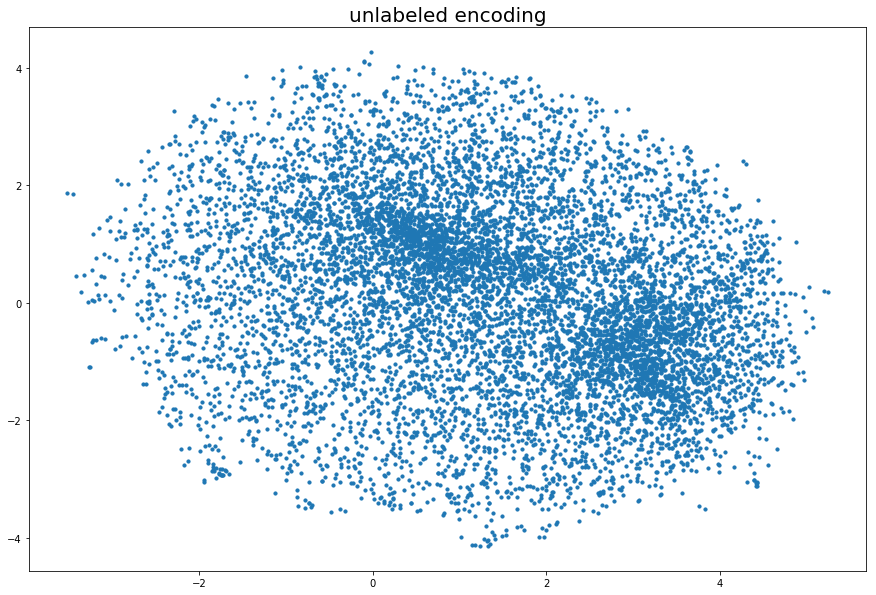

In [22]:
plot_tsne_df(tsne_df)

In [23]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)
print(props)

   acid      mass  volume  hydrophobicity  number_of_atoms
0     A   71.0779    88.6             1.8             13.0
1     R  156.1857   173.4            -4.5             26.0
2     N  114.1026   114.1            -3.5             17.0
3     D  115.0874   111.1            -3.5             16.0
4     B  114.5950   112.6            -3.5             16.5
5     C  103.1429   108.5             2.5             14.0
6     E  129.1140   138.4            -3.5             19.0
7     Q  128.1292   143.8            -3.5             20.0
8     Z  128.6216   141.1            -3.5             19.5
9     G   57.0513    60.1            -0.4             10.0
10    H  137.1393   153.2            -3.2             20.0
11    I  113.1576   166.7             4.5             22.0
12    L  113.1576   166.7             3.8             22.0
13    K  128.1723   168.6            -3.9             24.0
14    M  131.1961   162.9             1.9             20.0
15    F  147.1739   189.9             2.8             23

In [24]:
######################

In [25]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    
    res = dict()    
    res['hydrophobicity'] = df_concat['hydrophobicity'].mean()
    res['number_of_atoms'] = df_concat['number_of_atoms'].sum()    
    res['mass'] = df_concat['mass'].sum()
    res['volume'] = df_concat['volume'].sum()
#     res = df_concat.mean()

    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [26]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [27]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

acid  hydrophobicity      mass  number_of_atoms  volume
0  AAA             5.4  213.2337             39.0   265.8
1  LLL            11.4  339.4728             66.0   500.1
2  ALA             7.4  255.3134             48.0   343.9
3  LAA             7.4  255.3134             48.0   343.9
4  AAL             7.4  255.3134             48.0   343.9

In [28]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

acid  hydrophobicity      mass  number_of_atoms  volume        x0        x1
0  AAA             5.4  213.2337             39.0   265.8  3.281107 -0.006271
1  LLL            11.4  339.4728             66.0   500.1  1.531598 -3.869108
2  ALA             7.4  255.3134             48.0   343.9  3.071803 -0.340837
3  LAA             7.4  255.3134             48.0   343.9  2.962371 -0.371899
4  AAL             7.4  255.3134             48.0   343.9  2.925167 -0.532203

In [29]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

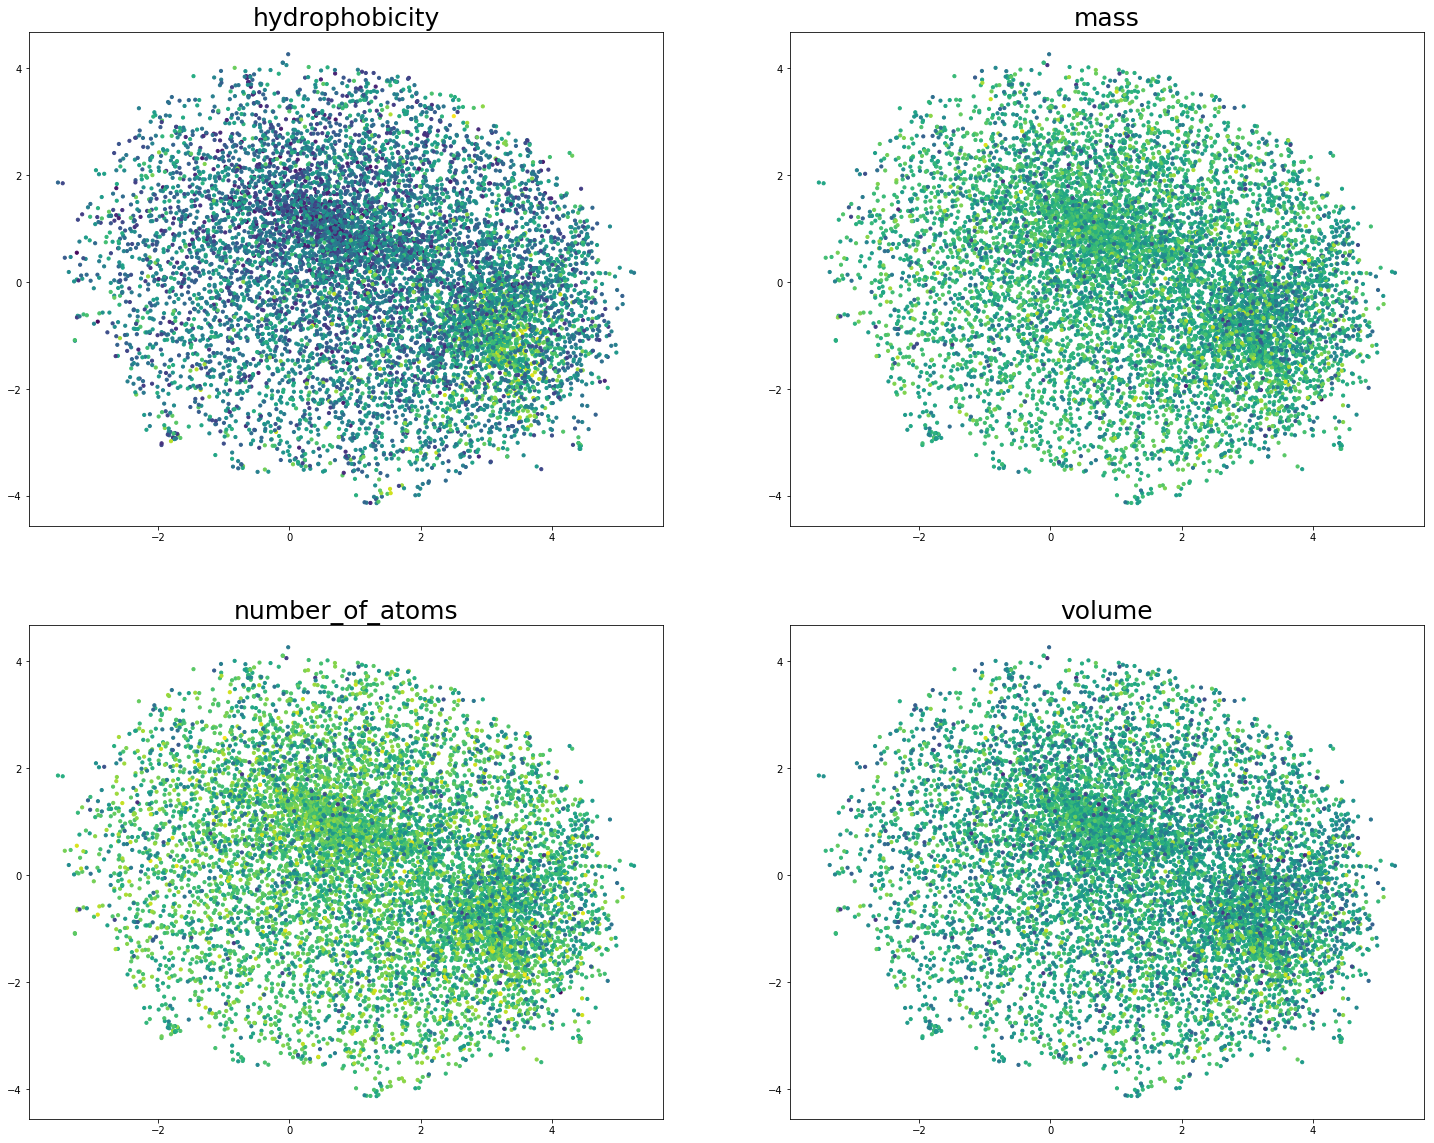

In [30]:
plot_embedding_properties(final_df)

In [31]:
######################

In [32]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

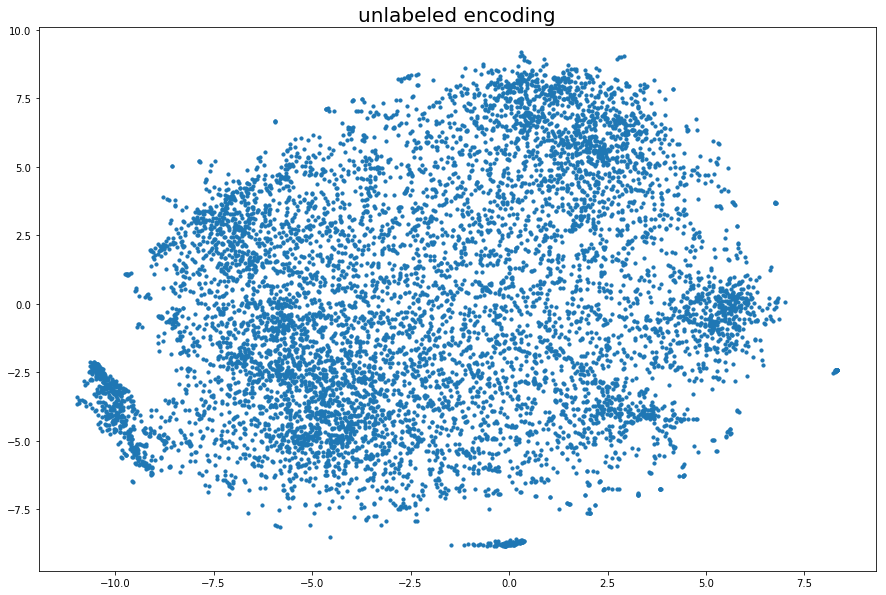

In [33]:
plot_tsne_df(gensim_tsne_df)

In [34]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

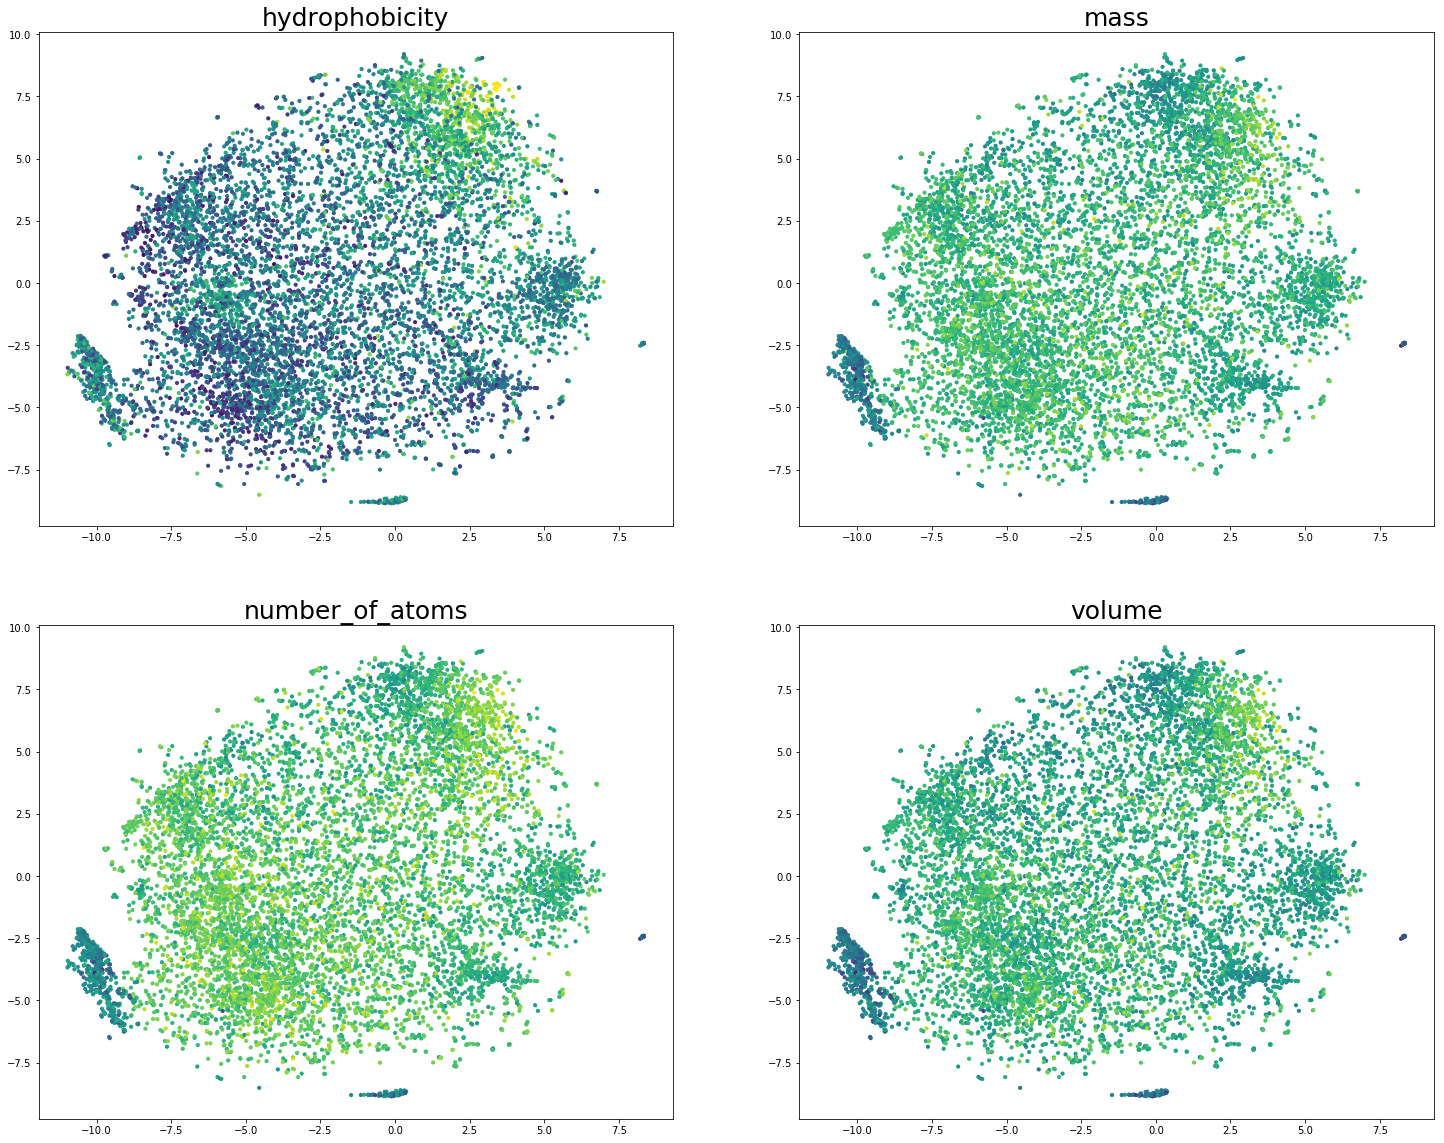

In [35]:
plot_embedding_properties(final_df_nice)

## Homework

Improve SkipGramModel to archive better embedding for amino acids codones. Visualize your space in the similar style as on the bottom example. You are only allowed to use vanilla tensorflow for this task.

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/